In [5]:
import requests
from datetime import datetime, timedelta
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

In [6]:
polygon_api_key = os.getenv("POLYGON_API_KEY")
ticker = "AAPL"

In [7]:
# Get date of earnings from 8 quarters ago
tick = yf.Ticker(ticker)
first_earnings = tick.earnings_dates.index[-1]

In [8]:
res = requests.get(
    f"https://api.polygon.io/vX/reference/financials",
    params={
        "apiKey": polygon_api_key, 
        "ticker": ticker, 

        "limit": 50
    }
)
if res.status_code != 200:
    print("Failed to fetch data: ", res.status_code)
data = res.json()
if "results" not in data:
    print("No data found")
reports = data["results"]

In [9]:
def extract_quarter_financials(quarter: dict):
    q = quarter["fiscal_period"]
    yr = quarter["fiscal_year"]
    eps = quarter["financials"]["income_statement"]["basic_earnings_per_share"]["value"]
    revenue = quarter["financials"]["income_statement"]["revenues"]["value"]
    income = quarter["financials"]["income_statement"]["income_loss_from_continuing_operations_before_tax"]["value"]
    return {
        "quarter": q,
        "year": yr,
        "eps": eps,
        "revenue": revenue,
        "income": income
    }


In [10]:
quarterly_financials = [
    extract_quarter_financials(q) for q in reports 
    if q["fiscal_period"] in ["Q1", "Q2", "Q3", "Q4"]
]
df = pd.DataFrame(quarterly_financials)
df = df.set_index(["year", "quarter"])
yoy_change = (df - df.shift(-4)) / df.shift(-4) * 100
yoy_change = yoy_change.dropna().rename(columns=lambda x: f"{x}_yoy_change")
df = pd.concat([df, yoy_change], axis=1)
df["fiscal_period"] = df.index.get_level_values("quarter") + df.index.get_level_values("year").astype(str)
df["pre_tax_profit_margin"] = df["income"] / df["revenue"] * 100
df

eps       revenue        income  eps_yoy_change  \
year quarter                                                     
2024 Q3       1.40  8.577700e+10  2.549400e+10       10.236220   
     Q2       1.53  9.075300e+10  2.805800e+10        0.000000   
     Q1       2.19  1.195750e+11  4.032300e+10       15.873016   
2023 Q4       1.47  8.949800e+10  2.699800e+10       13.953488   
     Q3       1.27  8.179700e+10  2.273300e+10        5.833333   
     Q2       1.53  9.483600e+10  2.838200e+10       -0.649351   
     Q1       1.89  1.171540e+11  3.562300e+10      -10.426540   
2022 Q4       1.29  9.014600e+10  2.465700e+10        3.200000   
     Q3       1.20  8.295900e+10  2.306600e+10       -8.396947   
     Q2       1.54  9.727800e+10  3.013900e+10        9.219858   
     Q1       2.11  1.239450e+11  4.124100e+10       24.117647   
2021 Q4       1.25  8.336000e+10  2.324800e+10       68.918919   
     Q3       1.31  8.143400e+10  2.436900e+10      101.538462   
     Q2       1.41  8.958400e+10  2.801100e+10      120.312500   
     Q1       1.70  1.114390e+11  3.357900e+10       34.920635   
2020 Q4       0.74  6.469800e+10  6.469800e+10      -75.737705   
     Q3       0.65  5.968500e+10  1.313700e+10      -70.454545   
     Q2       0.64  5.831300e+10  1.313500e+10      -74.089069   
     Q1       1.26  9.181900e+10  2.591800e+10      -70.142180   
2019 Q4       3.05  6.404000e+10  6.404000e+10        3.741497   
     Q3       2.20  5.380900e+10  1.191100e+10       -6.779661   
     Q2       2.47  5.801500e+10  1.379300e+10      -10.181818   
     Q1       4.22  8.431000e+10  2.390600e+10        7.653061   
2018 Q4       2.94  6.290000e+10  6.290000e+10       41.346154   
     Q3       2.36  5.326500e+10  1.328400e+10       40.476190   
     Q2       2.75  6.113700e+10  1.616800e+10       30.331754   
     Q1       3.92  8.829300e+10  2.703000e+10       15.976331   
2017 Q4       2.08  5.257900e+10  5.257900e+10       23.809524   
     Q3       1.68  4.540800e+10  1.130800e+10       17.482517   
     Q2       2.11  5.289600e+10  1.468400e+10       10.471204   
     Q1       3.38  7.835100e+10  2.418000e+10        2.424242   
2016 Q4       1.68  4.685200e+10  4.685200e+10      -14.720812   
     Q3       1.43  4.235800e+10  1.046900e+10      -23.118280   
     Q2       1.91  5.055700e+10  1.414200e+10      -18.376068   
     Q1       3.30  7.587200e+10  2.457300e+10        7.142857   
2015 Q4       1.97  5.150100e+10  5.150100e+10       37.762238   
     Q3       1.86  4.960500e+10  1.447300e+10             NaN   
     Q2       2.34  5.801000e+10  1.856400e+10             NaN   
     Q1       3.08  7.459900e+10  2.441600e+10             NaN   
2014 Q4       1.43  4.212300e+10  4.212300e+10             NaN   

              revenue_yoy_change  income_yoy_change fiscal_period  \
year quarter                                                        
2024 Q3                 4.865704          12.145339        Q32024   
     Q2                -4.305327          -1.141569        Q22024   
     Q1                 2.066511          13.193723        Q12024   
2023 Q4                -0.718834           9.494261        Q42023   
     Q3                -1.400692          -1.443683        Q32023   
     Q2                -2.510331          -5.829656        Q22023   
     Q1                -5.479043         -13.622366        Q12023   
2022 Q4                 8.140595           6.060736        Q42022   
     Q3                 1.872682          -5.346957        Q32022   
     Q2                 8.588587           7.597015        Q22022   
     Q1                11.222283          22.817833        Q12022   
2021 Q4                28.844787         -64.066895        Q42021   
     Q3                36.439641          85.498972        Q32021   
     Q2                53.626121         113.254663        Q22021   
     Q1                21.368126          29.558608        Q12021   
2020 Q4                 1.027483           1.027483        Q42020   


In [11]:
def make_bar_plot(
    df: pd.DataFrame,
    col: str, 
    title: str, 
    color="green", 
    target=7.5,
    n_quarters=4
):
    ax = df.iloc[:n_quarters].plot.bar(x="fiscal_period", y=col, color=color, rot=0)
    ax.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.2)
    ax.get_legend().remove()
    # Remove lines
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xlabel("")
    ax.set_title(title)
    ax.axhline(target, color='red', linewidth=0.5, linestyle='--')
    ax.tick_params(length=0)
    ax.set_ylim()
    ax.set_yticklabels([f"{int(x)}%" for x in ax.get_yticks()])
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='edge')

/var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_68948/1760033142.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(x)}%" for x in ax.get_yticks()])


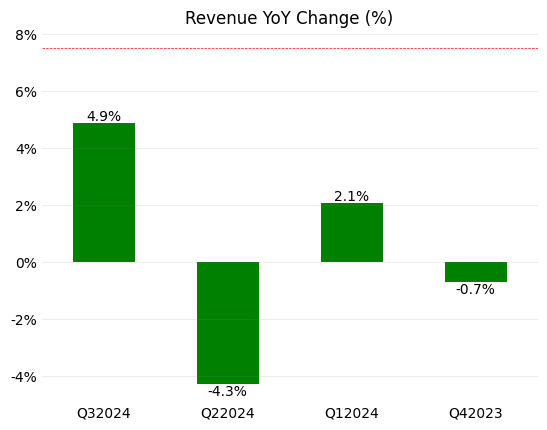

In [12]:
# Revenue YoY
make_bar_plot(df, "revenue_yoy_change", "Revenue YoY Change (%)", color="green", target=7.5)

/var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_68948/1760033142.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(x)}%" for x in ax.get_yticks()])


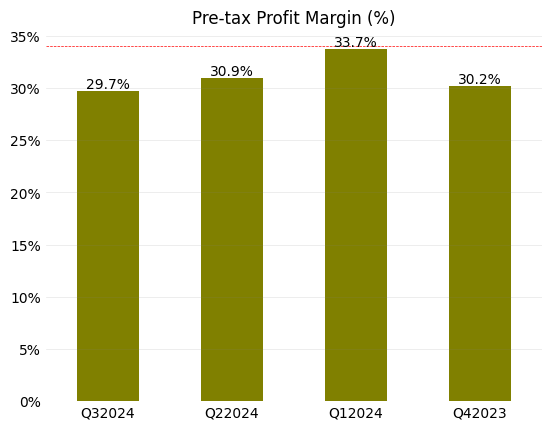

In [13]:
# PTPM
make_bar_plot(df, "pre_tax_profit_margin", "Pre-tax Profit Margin (%)", color="olive", target=34)

/var/folders/rw/8p8g2qln5h7_f_02pz80mnl80000gn/T/ipykernel_68948/1760033142.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(x)}%" for x in ax.get_yticks()])


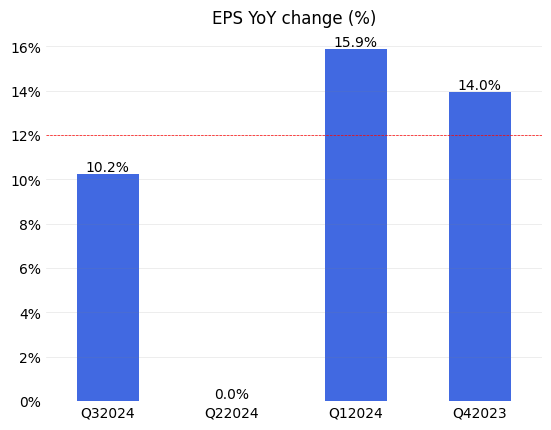

In [14]:
# PTPM
make_bar_plot(df, "eps_yoy_change", "EPS YoY change (%)", color="royalblue", target=12)